In [2]:
import matplotlib.pyplot as plt
import pathlib
import torch
import torch.nn.functional
import tqdm

# Env variables
DIR_PATH = pathlib.Path(__name__).resolve().parent
g = torch.Generator().manual_seed(2147483647) # default seed from the torch docs

In [3]:
DIR_PATH

PosixPath('/mnt/c/dev/course-neural-networks-zero-to-hero/makemore')

In [4]:
# reading data to tokens
def load_txt_to_list(fname):
    path = pathlib.Path(fname)
    if not path.exists():
        raise f"{fname} not found!"

    list_out = []
    with open(path, "r") as file:
        list_out = file.read().splitlines()

    return list_out

def construct_map_token_to_index(list_tokens):
    """
    Returns { token : index }

    Map each token in the vocab to a unique integer,
    which will be its index into the Bag of words vector

    TODO: https://en.wikipedia.org/wiki/Feature_hashing
    NOTE: Fatal flaw is set sorting is random, making debugging a little harder
    """
    dict_to_ix = {}
    dict_to_word = {}
    for i, token in enumerate(set(list_tokens)):
        dict_to_ix[token] = i
        dict_to_word[i] = token

    return dict_to_ix, dict_to_word

fname = DIR_PATH / "names.txt"
words = load_txt_to_list(fname)

dict_token_to_ix, dict_ix_to_token = construct_map_token_to_index("".join(words))

list_tokens_extra = ["."]
for token in list_tokens_extra:
    dict_token_to_ix[token] = len(dict_token_to_ix)
    dict_ix_to_token[len(dict_ix_to_token)] = token

list_documents = [ ["."] + list(string) + ["."] for string in words ]

# Exercise 1: Train a trigram language model

Train a trigram language model, i.e., take two characters as an input to predict the 3rd one using counting. Evaluate the loss. Did it improve over a bigram model?

In [10]:
# Calculating the ngrams
def construct_vector_ngram(tokens_context, dict_index):
    return list(map(lambda w: dict_index[w], tokens_context))

def construct_n_grams(list_documents, dict_index, size_context):
    """
    Constructs the list ngram indices to be used in other functions
    Returns list of list of indices (each list is size size_context)
    """
    if len(min(list_documents, key = len)) < size_context:
        raise("Smallest token is smaller than context size")

    list_out = []
    for tokens in tqdm.tqdm(list_documents):
        for j in range(0, len(tokens) - size_context + 1):
            vector = construct_vector_ngram(tokens[j:j+size_context], dict_index)
            list_out.append(vector)

    return list_out

SIZE_NGRAMS = 4
list_vectors = construct_n_grams(list_documents, dict_token_to_ix, size_context=SIZE_NGRAMS)
# Verify the mapping
n_bigrams = len(list_documents[0])+1-SIZE_NGRAMS
for i in range(n_bigrams):
    print(list_documents[0][i:i+SIZE_NGRAMS], list_vectors[i])

matrix_ngrams = torch.tensor(list_vectors, dtype = torch.int64)

  0%|          | 0/32033 [00:00<?, ?it/s]

100%|██████████| 32033/32033 [00:00<00:00, 52089.53it/s]

['.', 'e', 'm', 'm'] [26, 11, 0, 0]
['e', 'm', 'm', 'a'] [11, 0, 0, 22]
['m', 'm', 'a', '.'] [0, 0, 22, 26]


## Counting method
We'll use the counting method to get the loss based on the MLE, which is the best loss based on my understanding.

In [6]:
def construct_matrix_adjacency_ngram(list_vectors, dict_index, size_context = 2):
    """
    For the 2D case, A[i][j] is vertex i points to vertex j
    For the 3D case, A[i1][i2][i3] is vertex i1 and i2 point to i3
    Process easily generalizes, but has scaling issues
    """
    out = torch.zeros(tuple([len(dict_index)]*size_context), dtype=torch.int64)
    for vector in list_vectors:
        out[tuple(vector)] += 1

    return out

N = construct_matrix_adjacency_ngram(matrix_ngrams, dict_token_to_ix, size_context=SIZE_NGRAMS)

size_smoothing = 1 # 0
P = (N+size_smoothing) / (N+size_smoothing).sum(dim=SIZE_NGRAMS-1, keepdim=True) # divide by the column-wise sum to normalize N[i,:]
# Double-check these all sum to 1
matrix_ones = P.sum(dim=-1) 
torch.allclose(matrix_ones, torch.ones(size = matrix_ones.shape, dtype = matrix_ones.dtype))

True

In [7]:
def calculate_log_likelihood(ngrams, P):
    """
    Get the row of each window based on the indices
    e.g bigrams would be P[ bigrams[0, :], bigrams[1, :] ]
    """
    probs = P[tuple(ngrams.T)]
    log_probs = torch.log(probs)
    return -log_probs.sum().item()

log_likelihood = calculate_log_likelihood(matrix_ngrams, P) 
print(log_likelihood / matrix_ngrams.shape[0])

1.9636549244271087


# Exercise 4: Select rows of W
We saw our 1-hot vectors merely select a row of W, so producing these vectors explicitly feels wasteful. Can you delete our use of F.one_hot in favor of simply indexing into rows of W? Do it for the case of n=2 and n=3 to see a pattern.

torch.Size([164080, 3, 27])


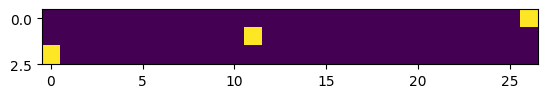

In [11]:
xs = matrix_ngrams[:,0:SIZE_NGRAMS-1]
ys = matrix_ngrams[:,-1] # vector
xenc = (
    torch.nn.functional.one_hot(xs, num_classes = len(dict_token_to_ix))
    .float()
)
print(xenc.shape)
plt.imshow(xenc[0])

In [15]:
# Getting the same result for logits = xenc @ W
W = torch.randn(
    size = (len(dict_token_to_ix)*(SIZE_NGRAMS-1), len(dict_token_to_ix)), 
    generator=g,
    requires_grad = False
)
expected = xenc.view(-1, len(dict_token_to_ix)*(SIZE_NGRAMS-1))[0] @ W
if SIZE_NGRAMS == 2:
    print(expected == W[0*len(dict_ix_to_token)+xs[0]])
elif SIZE_NGRAMS == 3:
    print(expected == W[0*len(dict_ix_to_token)+xs[0][0],:] + W[1*len(dict_ix_to_token)+xs[0][1],:])
elif SIZE_NGRAMS >= 4: 
    # using python syntax
    print(expected == sum(W[i * len(dict_ix_to_token) + xs[0][i], :] for i in range(SIZE_NGRAMS - 1)))
    # using torch syntax
    print(expected == W[torch.arange(SIZE_NGRAMS-1)*len(dict_ix_to_token) + xs[0][torch.arange(SIZE_NGRAMS-1)]].sum(dim=0))
    # using einstein summation notation


W_2 = W.reshape((SIZE_NGRAMS-1, len(dict_token_to_ix), len(dict_token_to_ix)))
if SIZE_NGRAMS == 2:
    print(expected == W_2[0,xs[0][0],:])
elif SIZE_NGRAMS == 3:
    print(expected == W_2[0,xs[0][0]] + W_2[1,xs[0][1],:])
elif SIZE_NGRAMS >= 3: 
    # using python syntax
    print(expected == sum(W_2[i,xs[0][i]] for i in range(SIZE_NGRAMS-1)))
    # using torch syntax
    print(expected == W_2[torch.arange(SIZE_NGRAMS-1),xs[0]].sum(dim=0))
    # using einstein summation notation
    print(expected == torch.einsum('jk,jkl -> l', xenc[0], W_2))

original_logits = xenc.view(-1, len(dict_token_to_ix)*(SIZE_NGRAMS-1))@W
print(original_logits == torch.einsum('ijk,jkl -> il', xenc, W_2))
print(original_logits == W_2[torch.arange(SIZE_NGRAMS-1).repeat(xs.shape[0], 1), xs].sum(dim=1))

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True])
tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True])
tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True])
tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True])
tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True])
tensor([[True, True, True,  ..., True, True, True],
        [True

## Neural Network Method

In [9]:
# Train the model
W = torch.randn(
    size = ((SIZE_NGRAMS-1), len(dict_token_to_ix), len(dict_token_to_ix)), 
    generator=g,
    requires_grad = True
)

LEARNING_RATE = 10 # 1 10 50
for i in range(100):

    # forward pass
    logits = W[torch.arange(SIZE_NGRAMS-1).repeat(xs.shape[0], 1), xs].sum(dim=1) # treat these as log-counts
    counts = logits.exp() # exp(log-counts) = counts
    probs = counts / counts.sum(dim = 1, keepdim=True) # exp(log-counts) / row-sum of exp(log-counts)
    # calculate loss (NLL)
    loss = -probs[torch.arange(ys.shape[0]),ys].log().mean()

    # backward pass
    # initialize gradients
    W.grad = None # more efficient than setting to 0
    loss.backward()
    if i % 10 == 0:
        print(f"Epoch {i} loss: {loss.item()}")

    # update
    W.data += -LEARNING_RATE * W.grad # going against the gradient reduces the loss

print(loss.item())

Epoch 0 loss: 3.8941891193389893
Epoch 10 loss: 3.2265682220458984
Epoch 20 loss: 2.956852674484253
Epoch 30 loss: 2.8211398124694824
Epoch 40 loss: 2.741563558578491
Epoch 50 loss: 2.68996262550354
Epoch 60 loss: 2.653670072555542
Epoch 70 loss: 2.6266300678253174
Epoch 80 loss: 2.6056482791900635
Epoch 90 loss: 2.588881731033325
2.5764482021331787


# Exercise 5:
Look up and use F.cross_entropy instead. You should achieve the same result. Can you think of why we'd prefer to use F.cross_entropy instead?

In [11]:
# Train the model
W = torch.randn(
    size = ((SIZE_NGRAMS-1), len(dict_token_to_ix), len(dict_token_to_ix)), 
    generator=g,
    requires_grad = True
)

LEARNING_RATE = 10 # 1 10 50
for i in range(100):

    # forward pass
    logits = W[torch.arange(SIZE_NGRAMS-1).repeat(xs.shape[0], 1), xs].sum(dim=1) # treat these as log-counts
    loss = torch.nn.functional.cross_entropy(logits, ys)

    # backward pass
    # initialize gradients
    W.grad = None # more efficient than setting to 0
    loss.backward()
    if i % 10 == 0:
        print(f"Epoch {i} loss: {loss.item()}")

    # update
    W.data += -LEARNING_RATE * W.grad # going against the gradient reduces the loss

print(loss.item())

Epoch 0 loss: 3.858079433441162
Epoch 10 loss: 3.2162160873413086
Epoch 20 loss: 2.958385944366455
Epoch 30 loss: 2.8256349563598633
Epoch 40 loss: 2.7446680068969727
Epoch 50 loss: 2.690458297729492
Epoch 60 loss: 2.6516213417053223
Epoch 70 loss: 2.622840404510498
Epoch 80 loss: 2.600919246673584
Epoch 90 loss: 2.5836875438690186
2.5710151195526123


# Exercise 2: Train the bigram and trigram models on a split dataset

Split up the dataset randomly into 80% train set, 10% dev set, 10% test set. 
Train the bigram and trigram models only on the training set. 
Evaluate them on dev and test splits. What can you see?

# Exercise 3,4: Tuning the model
Use the dev set to tune the strength of smoothing (or regularization) for the trigram model - i.e. try many possibilities and see which one works best based on the dev set loss. What patterns can you see in the train and dev set loss as you tune this strength? Take the best setting of the smoothing and evaluate on the test set once and at the end. How good of a loss do you achieve?